In [1]:
# %% [markdown]
# # COVID-19 Cases Prediction and Forecasting Project
# 
# **Project Overview:**
# 
# In this project we:
# 
# 1. Use five datasets:
#    - **Epidemiology Data** (`epidemiology.csv`):  
#      `date, location_key, new_confirmed, new_deceased, new_recovered, new_tested, cumulative_confirmed, cumulative_deceased, cumulative_recovered, cumulative_tested`
#    - **Geography Data** (`geography.csv`):  
#      `location_key, openstreetmap_id, latitude, longitude, elevation_m, area_sq_km, area_rural_sq_km, area_urban_sq_km`
#    - **Hospitalizations Data** (`hospitalizations.csv`):  
#      `date, location_key, new_hospitalized_patients, cumulative_hospitalized_patients, current_hospitalized_patients, new_intensive_care_patients, cumulative_intensive_care_patients, current_intensive_care_patients, new_ventilator_patients, cumulative_ventilator_patients, current_ventilator_patients`
#    - **Government Response Data** (`oxford-government-response.csv`):  
#      `date, location_key, school_closing, workplace_closing, cancel_public_events, restrictions_on_gatherings, public_transport_closing, stay_at_home_requirements, restrictions_on_internal_movement, international_travel_controls, income_support, debt_relief, fiscal_measures, international_support, public_information_campaigns, testing_policy, contact_tracing, emergency_investment_in_healthcare, investment_in_vaccines, facial_coverings, vaccination_policy, stringency_index`
#    - **Vaccinations Data** (`vaccinations.csv`):  
#      `date, location_key, new_persons_vaccinated, cumulative_persons_vaccinated, new_persons_fully_vaccinated, cumulative_persons_fully_vaccinated, new_vaccine_doses_administered, cumulative_vaccine_doses_administered, new_persons_vaccinated_pfizer, cumulative_persons_vaccinated_pfizer, new_persons_fully_vaccinated_pfizer, cumulative_persons_fully_vaccinated_pfizer, new_vaccine_doses_administered_pfizer, cumulative_vaccine_doses_administered_pfizer, new_persons_vaccinated_moderna, cumulative_persons_vaccinated_moderna, new_persons_fully_vaccinated_moderna, cumulative_persons_fully_vaccinated_moderna, new_vaccine_doses_administered_moderna, cumulative_vaccine_doses_administered_moderna, new_persons_vaccinated_janssen, cumulative_persons_vaccinated_janssen, new_persons_fully_vaccinated_janssen, cumulative_persons_fully_vaccinated_janssen, new_vaccine_doses_administered_janssen, cumulative_vaccine_doses_administered_janssen, new_persons_vaccinated_sinovac, total_persons_vaccinated_sinovac, new_persons_fully_vaccinated_sinovac, total_persons_fully_vaccinated_sinovac, new_vaccine_doses_administered_sinovac, total_vaccine_doses_administered_sinovac`
# 
# 2. Merge the datasets (with Epidemiology as the core) to generate a unified view.
# 3. Visualize:
#    - **Worldwide Spread:** A geographical map based on the latest cumulative confirmed cases.
#    - **Daily New Cases:** A time-series plot of global daily new confirmed cases.
#    - **Daily New Deaths:** A time-series plot of global daily new deaths.
# 4. Use Facebook Prophet to forecast future new confirmed cases.
# 5. Include steps to upload the project to GitHub.


In [2]:
# %% [markdown]
# ## 1. Prerequisites and Library Installation
# 
# Ensure you have Python 3.7+ installed and run:
# 
# ```bash
# pip install pandas numpy matplotlib seaborn geopandas plotly prophet
# ```
# 
# *Note:* If you encounter issues with Prophet, try installing it as `fbprophet` (and adjust the import accordingly).


In [3]:
# %% [markdown]
# ## 2. Import Libraries


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
from prophet import Prophet  # Alternatively: from fbprophet import Prophet

# Ensure inline plotting if using a notebook:
%matplotlib inline


In [6]:
# %% [markdown]
# ## 3. Load the Datasets
# 
# Adjust the file paths if your CSV files are located in a different folder.


In [8]:
# Load Epidemiology Data with date parsing
epi = pd.read_csv('Datasets/epidemiology.csv', parse_dates=['date'])

# Load Geography Data
geo = pd.read_csv('Datasets/geography.csv')

# Load Hospitalizations Data
# To avoid the warning, we parse dates normally then explicitly convert the 'date' column.
hosp = pd.read_csv('Datasets/hospitalizations.csv', parse_dates=['date'])
hosp['date'] = pd.to_datetime(hosp['date'], format='%Y-%m-%d', errors='coerce')

# Load Government Response Data
gov = pd.read_csv('Datasets/oxford-government-response.csv', parse_dates=['date'])

# Load Vaccinations Data
vacc = pd.read_csv('Datasets/vaccinations.csv', parse_dates=['date'])

# Optional: Print column names to verify
print("Epidemiology Columns:", epi.columns.tolist())
print("Geography Columns:", geo.columns.tolist())
print("Hospitalizations Columns:", hosp.columns.tolist())
print("Government Response Columns:", gov.columns.tolist())
print("Vaccinations Columns:", vacc.columns.tolist())


/var/folders/z9/_kk4dvt12l1146n5_pym3vg40000gn/T/ipykernel_52402/3767823345.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hosp = pd.read_csv('Datasets/hospitalizations.csv', parse_dates=['date'])


Epidemiology Columns: ['date', 'location_key', 'new_confirmed', 'new_deceased', 'new_recovered', 'new_tested', 'cumulative_confirmed', 'cumulative_deceased', 'cumulative_recovered', 'cumulative_tested']
Geography Columns: ['location_key', 'openstreetmap_id', 'latitude', 'longitude', 'elevation_m', 'area_sq_km', 'area_rural_sq_km', 'area_urban_sq_km']
Hospitalizations Columns: ['date', 'location_key', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'current_hospitalized_patients', 'new_intensive_care_patients', 'cumulative_intensive_care_patients', 'current_intensive_care_patients', 'new_ventilator_patients', 'cumulative_ventilator_patients', 'current_ventilator_patients']
Government Response Columns: ['date', 'location_key', 'school_closing', 'workplace_closing', 'cancel_public_events', 'restrictions_on_gatherings', 'public_transport_closing', 'stay_at_home_requirements', 'restrictions_on_internal_movement', 'international_travel_controls', 'income_support', 'debt_reli

In [9]:
epi_geo = pd.merge(epi, geo, on='location_key', how='left')
print("Merged Epidemiology & Geography Data (sample):")
print(epi_geo.head())


Merged Epidemiology & Geography Data (sample):
        date location_key  new_confirmed  new_deceased  new_recovered  \
0 2020-01-01           AD            0.0           0.0            NaN   
1 2020-01-02           AD            0.0           0.0            NaN   
2 2020-01-03           AD            0.0           0.0            NaN   
3 2020-01-04           AD            0.0           0.0            NaN   
4 2020-01-05           AD            0.0           0.0            NaN   

   new_tested  cumulative_confirmed  cumulative_deceased  \
0         NaN                   0.0                  0.0   
1         NaN                   0.0                  0.0   
2         NaN                   0.0                  0.0   
3         NaN                   0.0                  0.0   
4         NaN                   0.0                  0.0   

   cumulative_recovered  cumulative_tested  openstreetmap_id   latitude  \
0                   NaN                NaN            9407.0  42.558333   
1  

In [10]:
# %% [markdown]
# ### b. Optionally Merge Additional Datasets
# 
# We now merge Government Response, Vaccinations, and Hospitalizations data into the core dataset.
# These merges use both `date` and `location_key` as common keys.


In [11]:
# Merge with Government Response Data
epi_geo_gov = pd.merge(epi_geo, gov, on=['date', 'location_key'], how='left')
# Merge with Vaccinations Data
epi_geo_gov_vacc = pd.merge(epi_geo_gov, vacc, on=['date', 'location_key'], how='left')
# Merge with Hospitalizations Data
full_data = pd.merge(epi_geo_gov_vacc, hosp, on=['date', 'location_key'], how='left')

# Fill missing numerical values with 0 (for simplicity)
full_data.fillna(0, inplace=True)

print("Full Merged Data Sample:")
print(full_data.head())


Full Merged Data Sample:
        date location_key  new_confirmed  new_deceased  new_recovered  \
0 2020-01-01           AD            0.0           0.0            0.0   
1 2020-01-02           AD            0.0           0.0            0.0   
2 2020-01-03           AD            0.0           0.0            0.0   
3 2020-01-04           AD            0.0           0.0            0.0   
4 2020-01-05           AD            0.0           0.0            0.0   

   new_tested  cumulative_confirmed  cumulative_deceased  \
0         0.0                   0.0                  0.0   
1         0.0                   0.0                  0.0   
2         0.0                   0.0                  0.0   
3         0.0                   0.0                  0.0   
4         0.0                   0.0                  0.0   

   cumulative_recovered  cumulative_tested  ...  \
0                   0.0                0.0  ...   
1                   0.0                0.0  ...   
2                   0.

In [12]:
# %% [markdown]
# ## 5. Visualizations
# 
# We generate three visualizations:
# 
# 1. **Geographical Visualization:** Interactive map showing the worldwide spread of COVID-19.
# 2. **Daily New Confirmed Cases:** Time-series plot of global daily new cases.
# 3. **Daily New Deaths:** Time-series plot of global daily deaths.


In [13]:
# ### a. Geographical Visualization of COVID-19 Spread
# 
# We'll use the latest available date from the Epidemiology data.
latest_date = epi['date'].max()
print("Latest Date in Epidemiology Data:", latest_date)

# Filter the merged epidemiology-geography data for the latest date.
latest_data = epi_geo[epi_geo['date'] == latest_date]

# We use the `latitude`, `longitude`, and `cumulative_confirmed` (total cases) for the map.
agg_geo = latest_data[['location_key', 'latitude', 'longitude', 'cumulative_confirmed']].dropna()

# Create an interactive geographical scatter plot using Plotly Express.
fig_geo = px.scatter_geo(
    agg_geo,
    lat='latitude',
    lon='longitude',
    hover_name='location_key',
    size='cumulative_confirmed',
    projection='natural earth',
    title=f"Worldwide COVID-19 Spread as of {latest_date.date()}"
)
fig_geo.show()


Latest Date in Epidemiology Data: 2022-12-30 00:00:00


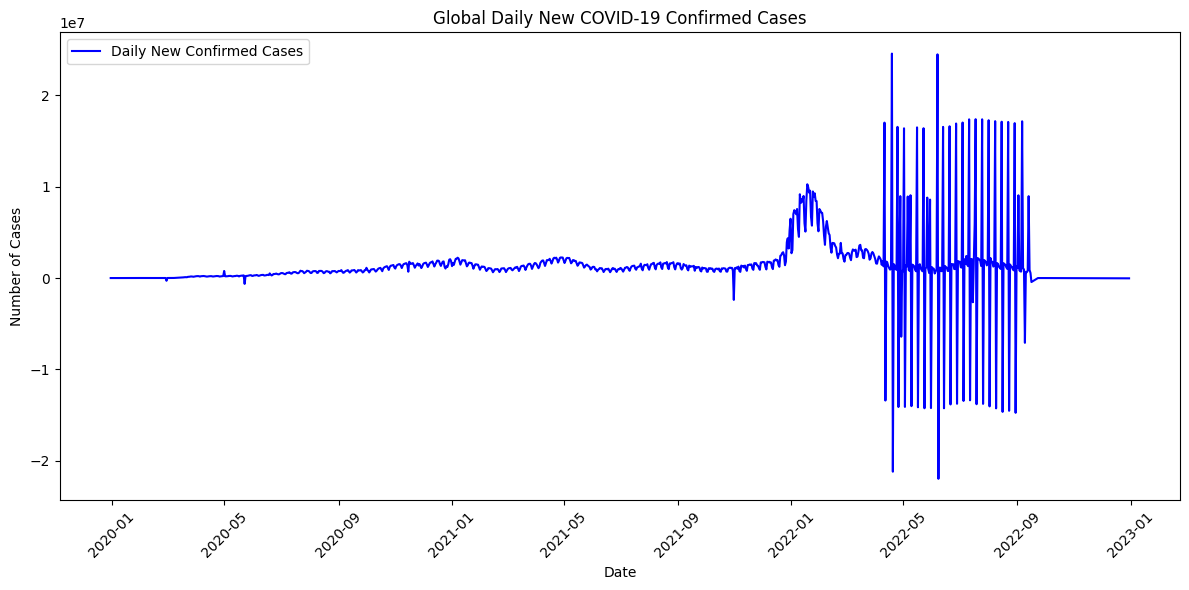

In [14]:
# ### b. Global Daily New Confirmed Cases Time-Series Plot
# 
# Aggregate the daily new confirmed cases globally.
global_daily = epi.groupby('date').agg({
    'new_confirmed': 'sum',
    'new_deceased': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=global_daily, x='date', y='new_confirmed', color='blue', label='Daily New Confirmed Cases')
plt.title("Global Daily New COVID-19 Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


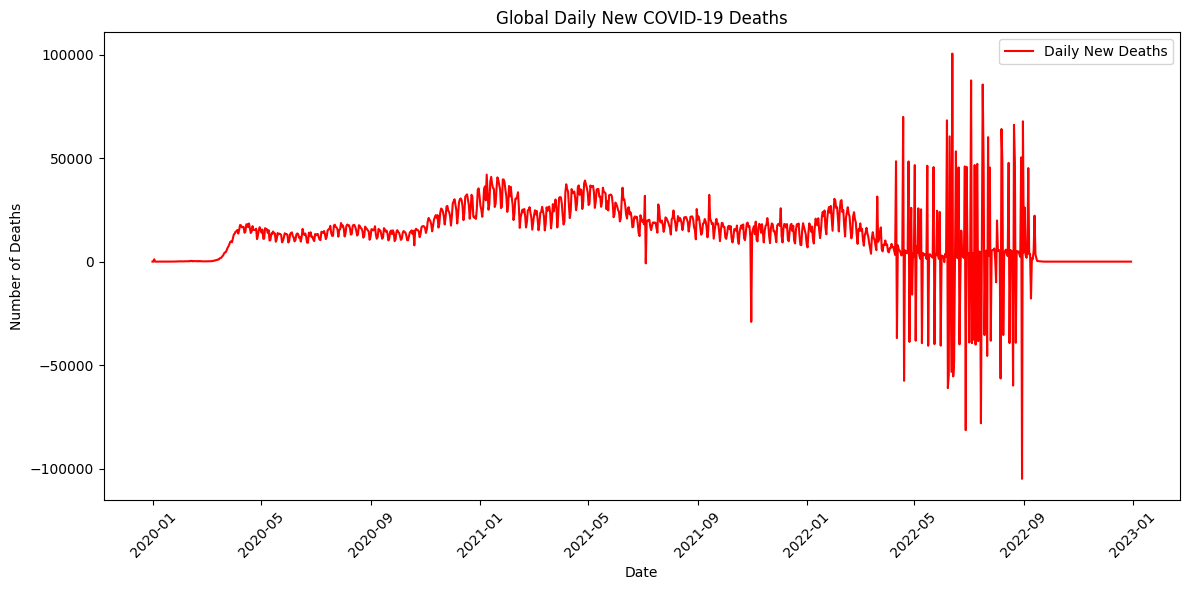

In [15]:
# ### c. Global Daily New Deaths Time-Series Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=global_daily, x='date', y='new_deceased', color='red', label='Daily New Deaths')
plt.title("Global Daily New COVID-19 Deaths")
plt.xlabel("Date")
plt.ylabel("Number of Deaths")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# %% [markdown]
# ## 6. COVID-19 Cases Prediction with Facebook Prophet
# 
# We'll use the global daily new confirmed cases for forecasting.
# Prophet expects a DataFrame with columns:
#  - `ds` (date)
#  - `y` (the metric to forecast)


23:01:34 - cmdstanpy - INFO - Chain [1] start processing
23:01:35 - cmdstanpy - INFO - Chain [1] done processing


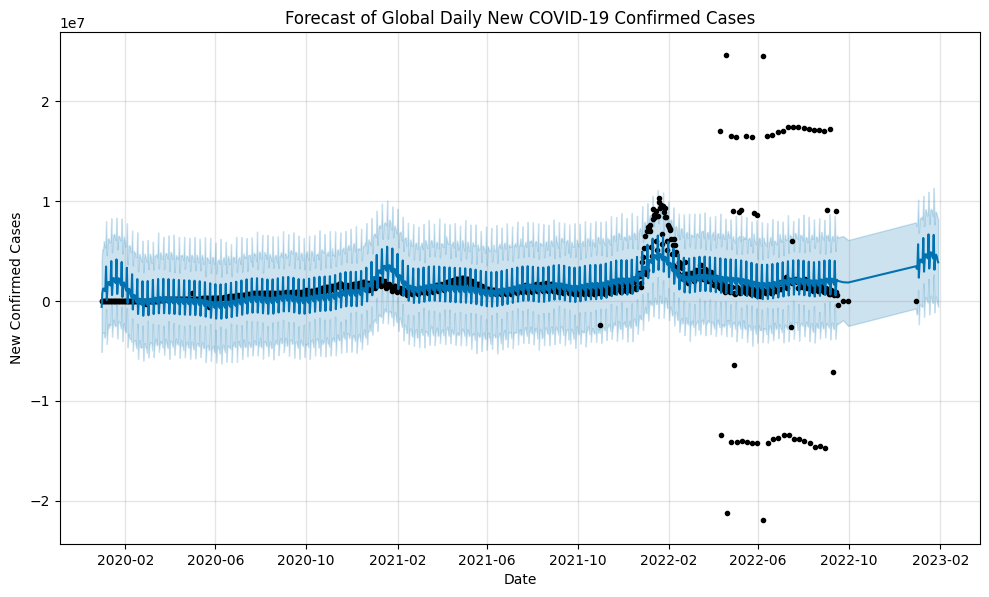

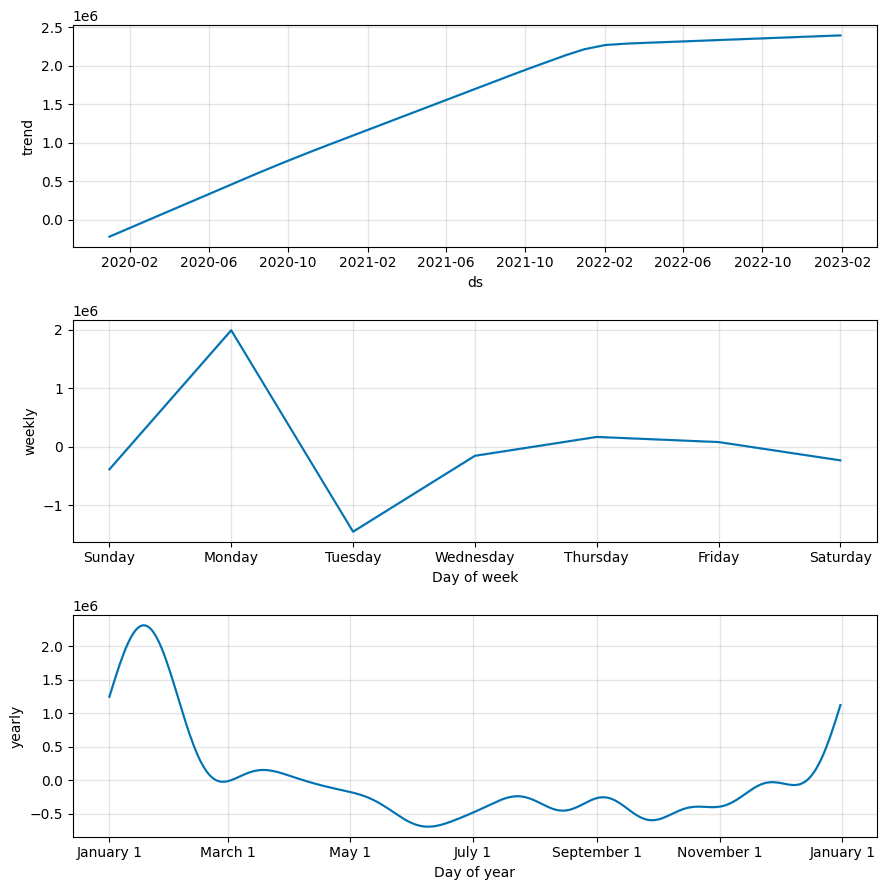

In [17]:
# Prepare data for Prophet: use global daily new confirmed cases.
df_prophet = global_daily[['date', 'new_confirmed']].rename(columns={'date': 'ds', 'new_confirmed': 'y'})

# Initialize and fit the Prophet model.
model = Prophet()
model.fit(df_prophet)

# Create a DataFrame to hold predictions for the next 30 days.
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast.
fig_prophet = model.plot(forecast)
plt.title("Forecast of Global Daily New COVID-19 Confirmed Cases")
plt.xlabel("Date")
plt.ylabel("New Confirmed Cases")
plt.show()

# Plot forecast components (trend, seasonality, etc.).
fig_components = model.plot_components(forecast)
plt.show()
